# Proyecto 1: Entrega 1 - BI

| ID | Nombre           | Código    | Correo                       |
|----|------------------|-----------|------------------------------|
| 1  | Adrian Velasquez | 202222737 | a.velasquezs@uniandes.edu.co |
| 2  | xxx              | xxx       | xxx@uniandes.edu.co          |
| 3  | yyy              | yyy       | yyy@uniandes.edu.co          |

In [1192]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from nltk import SnowballStemmer, WordNetLemmatizer

import nltk
nltk.download('punkt_tab')

from nltk.corpus import stopwords
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import ComplementNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from sklearn import tree

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/adrianv/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [1193]:
TRAIN = "data/train_data.xlsx"
TEST = "data/test_data.xlsx"

## Entendimiento y perfilamiento de los datos

De forma preliminar, sabemos que el objetivo de nuestro modelo es categorizar las opiniones de acuerdo a los ODS (objetivos de desarrollo sostenible) 1, 3 y 4, los cuales son “Fin de la pobreza”, “Salud y bienestar” y “Educación de calidad” respectivamente. En primer lugar, haremos un análisis preliminar de los datos, la calidad de los mismos, y validaremos cualquier caso particular que encontremos.

In [1194]:
df_original = pd.read_excel(TRAIN)
df_original.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


In [1195]:
df_original.shape

(2424, 2)

In [1196]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [1197]:
print(df_original.isnull().sum())

textos    0
labels    0
dtype: int64


In [1198]:
print(df_original.duplicated().sum())

0


Podemos ver una completitud en los datos, pues no hay nulos en ninguno de los entries en ninguna de las dos columnas. Asimismo, no hay duplicados completos, lo cual es una buena señal. Ahora nos centraremos a comprender cada columna por separado

### Columna textos

In [1199]:
print(df_original["textos"].duplicated().sum())

0


Toca convertir la columna de textos a tipo string, con el fin de poderla manipular adecuadamente y hacer un análisis más riguroso.

In [1200]:
df_original["textos"] = df_original["textos"].astype("string")
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   string
 1   labels  2424 non-null   int64 
dtypes: int64(1), string(1)
memory usage: 38.0 KB


In [1201]:
df_text_analysis = df_original.copy()

In [1202]:
df_text_analysis["textos_lower"] = df_text_analysis["textos"].str.lower()
df_text_analysis.head()

,textos,labels,textos_lower
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"""aprendizaje"" y ""educación"" se consideran sinó..."
1,Para los niños más pequeños (bebés y niños peq...,4,para los niños más pequeños (bebés y niños peq...
2,"Además, la formación de especialistas en medic...",3,"además, la formación de especialistas en medic..."
3,En los países de la OCDE se tiende a pasar de ...,4,en los países de la ocde se tiende a pasar de ...
4,Este grupo se centró en las personas que padec...,3,este grupo se centró en las personas que padec...


In [1203]:
print(df_text_analysis["textos_lower"].duplicated().sum())

0


Podemos ver que incluso cuando todas las entries de la columna han sido normalizadas de tal manera que están en minúscula, no hay duplicados entre ellas.

In [1204]:
df_text_analysis["textos_lower_split"] = df_text_analysis["textos_lower"].str.replace("(","").str.replace(")","").str.replace('"', "").str.replace(",","").str.split(" ")
df_text_analysis.head()

,textos,labels,textos_lower,textos_lower_split
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,"""aprendizaje"" y ""educación"" se consideran sinó...","[aprendizaje, y, educación, se, consideran, si..."
1,Para los niños más pequeños (bebés y niños peq...,4,para los niños más pequeños (bebés y niños peq...,"[para, los, niños, más, pequeños, bebés, y, ni..."
2,"Además, la formación de especialistas en medic...",3,"además, la formación de especialistas en medic...","[además, la, formación, de, especialistas, en,..."
3,En los países de la OCDE se tiende a pasar de ...,4,en los países de la ocde se tiende a pasar de ...,"[en, los, países, de, la, ocde, se, tiende, a,..."
4,Este grupo se centró en las personas que padec...,3,este grupo se centró en las personas que padec...,"[este, grupo, se, centró, en, las, personas, q..."


In [1205]:
df_text_analysis["len_texts"] = df_text_analysis["textos_lower_split"].str.len()

df_text_analysis["len_texts"].describe()

count    2424.000000
mean      107.953795
std        35.578358
min        41.000000
25%        81.000000
50%       102.000000
75%       129.000000
max       260.000000
Name: len_texts, dtype: float64

In [1206]:
df_text_analysis.shape

(2424, 5)

In [1207]:
print(len(df_text_analysis["len_texts"].unique()))

184


### Columna label (target)

In [1208]:
df_original['labels'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2424 entries, 0 to 2423
Series name: labels
Non-Null Count  Dtype
--------------  -----
2424 non-null   int64
dtypes: int64(1)
memory usage: 19.1 KB


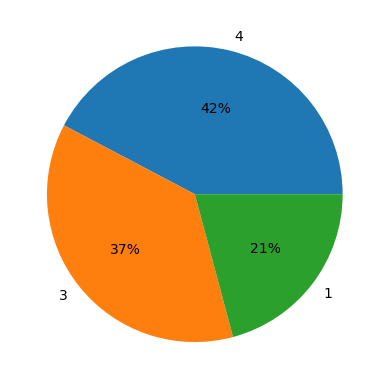

In [1209]:
plt.pie(df_original['labels'].value_counts(), labels=df_original['labels'].unique(), autopct='%1.0f%%')
plt.show()

### Duplicados parciales

En general, no se observaron duplicados parciales. Hay textos cuya longitud es equivalente, sin embargo, no son idénticos.

## Preparación de los datos

En esta etapa, vamos a definir ciertas funciones y demás herramientas que serán útiles a la hora de desarrollar los modelos.

In [1210]:
df = df_original.copy()
df.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


Ahora que tenemos un dataframe sobre el cual podemos trabajar, ejecutaremos un TfidVectorizer para garantizar que las palabras tokenizadas sean adecuadamente analizadas con base en en el TF-IDF, para medir la importancia de ciertas palabras en comparación a los demás textos. A este TfidVectorizer le agregaremos un Stemmer para minimizar la redundancia de las palabras que vamos a analizar. Utilizaremos también un conjunto de StopWords en español que ofrece la librería NLTK, la cual también pasaremos por el Stemmer para garantizar que ningún StopWord quede en el conjunto final de palabras escogidas.

In [1211]:
from nltk import word_tokenize
import re

spanish_sw = list(stopwords.words("spanish"))
# Se utilizó un stemmer debido a que no hay un Lemmatizer en español disponible en la librería NLTK
stemmer = SnowballStemmer(language="spanish")

otras_palabras = ["tambien"]

spanish_sw.extend(otras_palabras)

# Tokenizador utilizando stemming
def stemmed_tokenizer(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

nuevas_stopwords = [stemmer.stem(token) for token in spanish_sw]

spanish_sw.extend(nuevas_stopwords) # agregar los stopwords lematizados a los stopwords originales

# Limpiar los textos antes de nada
def clean_text(s):
    s = s.replace("\n", " ").replace("(", " ").replace(")", " ").replace(",", " ").replace(".", " ").replace("?", " ").replace("!", " ").replace("'", " ")
    s = s.lower()
    s = re.sub(r'\d+', ' ', s)
    s = re.sub(r'[^\w]', ' ', s)
    return s


tfidf_word = TfidfVectorizer(
    preprocessor=clean_text,
    tokenizer=stemmed_tokenizer,
    stop_words=spanish_sw,
    max_df=0.9,
    min_df=3,
    max_features=10_000,
    token_pattern=None
)

Más allá del vectorizer, como vimos en el entendimiento y perfilamiento de los datos, no hay mucho que hacer antes de seguir con la construcción de los modelos. Para tener una idea de cómo quedarán las palabras escogidas por el TF-IDF Vectorizer, lo utilizaremos a continuación

In [1212]:
tfidf_matrix = tfidf_word.fit_transform(df_original['textos'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_word.get_feature_names_out())

tfidf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Columns: 3081 entries, abaj to â
dtypes: float64(3081)
memory usage: 57.0 MB


In [1259]:
print(  f"Ejemplos de palabras escogidas por el TF-IDF Vectorizer: {tfidf_df.columns.tolist()[0:10]}" )

Ejemplos de palabras escogidas por el TF-IDF Vectorizer: ['abaj', 'abandon', 'abarc', 'abiert', 'abog', 'abol', 'abord', 'abordaj', 'aborigen', 'abort']


Antes de continuar, recordemos que el objetivo del TF-IDF Vectorizer es medir la importancia de cada una de las palabras en cada uno de los documentos en relación a los demás documentos. Esto ayudará a los clasificadores (modelos) a clasificar de forma efectiva cada documento.

## Construcción de los modelos

### Preparación inicial

En general, debido a que en el vectorizer incluimos un preprocesador para la limpieza de los textos y la eliminación de los stopwords, no es necesario hacer muchos procedimientos de forma manual.

In [1214]:
x = df["textos"]
y = df["labels"]

x_train, x_test, y_train, y_test = train_test_split(x, y)

### Modelo 1: LinearSVC

El primer modelo que utilizaremos es el LinearSVC, pues es un modelo estándar de la librería SciKit Learn que es utilizado para tareas de clasificación.

In [1215]:
pipe_linear_svm = Pipeline([
    ("vector", tfidf_word),
    ("clf", LinearSVC(class_weight="balanced", random_state=42))
])

In [1216]:
pipe_linear_svm.fit(x_train, y_train)

,steps,"[('vector', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,<function cle...t 0x362ea5120>
,tokenizer,<function ste...t 0x362ea7600>


In [1217]:
pred_linear_svm = pipe_linear_svm.predict(x_test)

In [1218]:
cm_linear_svm = confusion_matrix(y_test, pred_linear_svm)

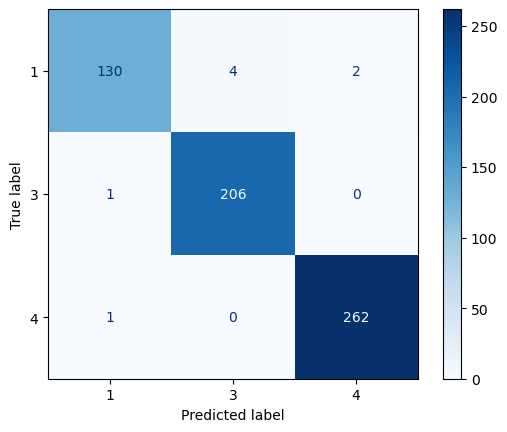

In [1219]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_linear_svm, display_labels=pipe_linear_svm.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [1220]:
print(classification_report(y_test, pred_linear_svm))

              precision    recall  f1-score   support

           1       0.98      0.96      0.97       136
           3       0.98      1.00      0.99       207
           4       0.99      1.00      0.99       263

    accuracy                           0.99       606
   macro avg       0.99      0.98      0.98       606
weighted avg       0.99      0.99      0.99       606



Con base en la matriz de confusión y las métricas del reporte de clasificación, podemos concluir que el modelo LinearSVC será un modelo útil a la hora de abordar el problema.

### Modelo 2: DecisionTreeClassifier

El segundo modelo que utilizaremos será el DecisionTreeClassifier, pues es un modelo que trabajamos en clase y puede ser aplicado en este contexto.

In [1221]:
pipe_dec_tree = Pipeline([
    ("vector", tfidf_word),
    ("clf", DecisionTreeClassifier(random_state=42,class_weight="balanced"))
])

In [1222]:
pipe_dec_tree.fit(x_train, y_train)

,steps,"[('vector', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,<function cle...t 0x362ea5120>
,tokenizer,<function ste...t 0x362ea7600>


In [1223]:
pred_dec_tree = pipe_dec_tree.predict(x_test)

In [1224]:
cm_dec_tree = confusion_matrix(y_test, pred_dec_tree)

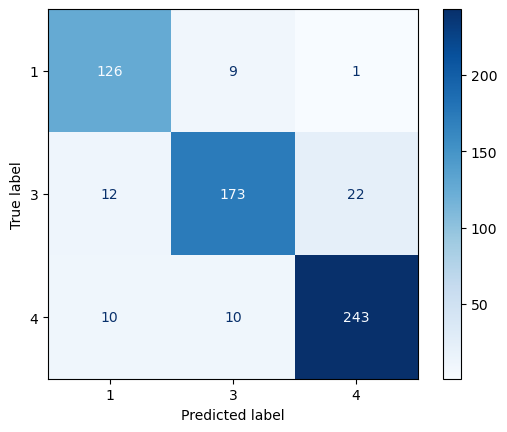

In [1225]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dec_tree, display_labels=pipe_dec_tree.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [1226]:
print(classification_report(y_test, pred_dec_tree))

              precision    recall  f1-score   support

           1       0.85      0.93      0.89       136
           3       0.90      0.84      0.87       207
           4       0.91      0.92      0.92       263

    accuracy                           0.89       606
   macro avg       0.89      0.90      0.89       606
weighted avg       0.90      0.89      0.89       606



Con base en la matriz de confusión y las métricas del reporte de clasificación, podemos concluir que el modelo DecisionTreeClassifier será un modelo útil a la hora de abordar el problema. Cabe resaltar que en general, las métricas fueron inferiores a las obtenidas en el modelo LinearSVC, sin embargo, al modificar los parámetros podríamos obtener resultados más precisos. A continuación se mostrará una representación gráfica del árbol de decision generado.

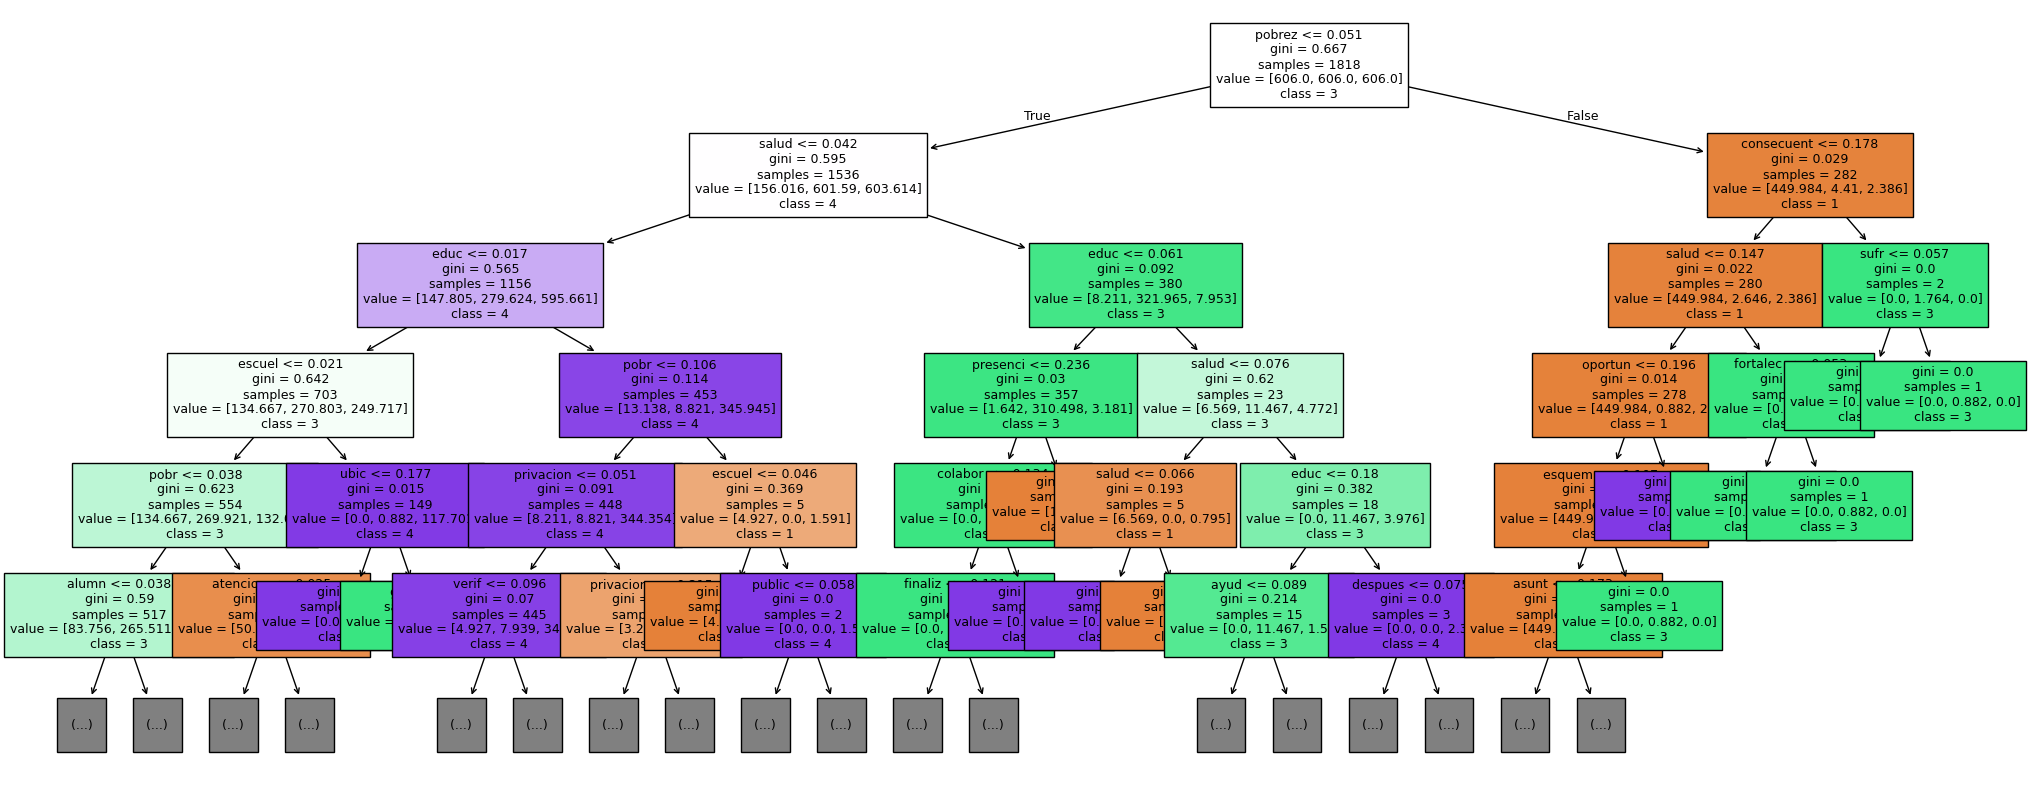

In [1227]:
dec_tree = pipe_dec_tree.named_steps["clf"]
tfidf_vectorizer = pipe_dec_tree.named_steps["vector"]

fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(dec_tree, max_depth=5 if dec_tree.tree_.max_depth > 5 else 2, feature_names=tfidf_vectorizer.get_feature_names_out(), class_names=["1", "3", "4"], filled=True, fontsize=9)

### Modelo 3: Naive Bayes

El tercer modelo que utilizaremos será el de ComplementNaiveBayes, el cual se basa en el teorema de Bayes. Este modelo también es estándar en la librería de SciKit Learn. De acuerdo al diagrama de guía que provee SciKit Learn, que se puede encontrar en `documents/sklearn_model_cheat_sheet.jpeg` y en la página oficial de la librería, este modelo (Naive Bayes) debería ser utilizado en caso de que el modelo LinearSVC no haya funcionado.

In [1228]:
pipe_comp_nb = Pipeline([
    ("vector", tfidf_word),
    ("clf", ComplementNB())
])

In [1229]:
pipe_comp_nb.fit(x_train, y_train)

,steps,"[('vector', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,<function cle...t 0x362ea5120>
,tokenizer,<function ste...t 0x362ea7600>


In [1230]:
pred_comb_nb = pipe_comp_nb.predict(x_test)

In [1231]:
cm_comp_nb = confusion_matrix(y_test, pred_comb_nb)

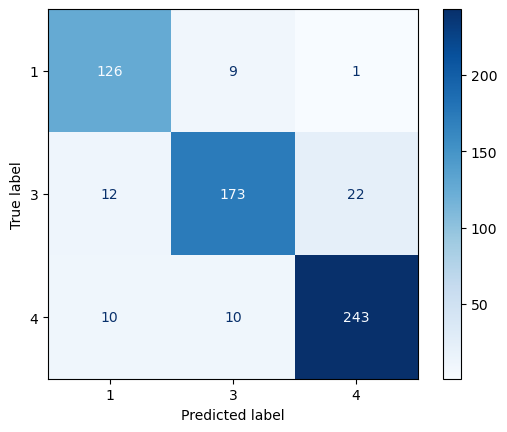

In [1232]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dec_tree, display_labels=pipe_comp_nb.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [1233]:
print(classification_report(y_test, pred_comb_nb))

              precision    recall  f1-score   support

           1       0.97      0.99      0.98       136
           3       0.99      0.96      0.98       207
           4       0.97      1.00      0.98       263

    accuracy                           0.98       606
   macro avg       0.98      0.98      0.98       606
weighted avg       0.98      0.98      0.98       606



Con base en la matriz de confusión y las métricas del reporte de clasificación, podemos concluir que el modelo ComplementNaiveBayes será un modelo útil a la hora de abordar el problema. Podemos observar que las métricas son muy similares a las obtenidas por el modelo LinearSVC, y en general son muy satisfactorias.

### Búsqueda de parámetros

Pese a que los resultados de los 3 modelos en general fueron satisfactorios, intentaremos mejorarlos aún más utilizando GridSearchCV con el fin de garantizar un modelo todavía mejor. Se definiran los grids de parámetros para cada uno, y posteriormente los compararemos entre sí para utilizar el mejor entre todos.

In [1234]:
cv_tree = KFold(n_splits=10, shuffle=True, random_state = 0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = "f1_macro"

Definimos los parámetros apoyándonos en la documentación que ofrece SciKit Learn, al igual que los ejemplos vistos en clase.

In [1235]:
param_svm = {"clf__C": [0.1, 0.3, 0.5, 1, 2, 3]}
param_tree = {'clf__criterion':['gini', 'entropy'],'clf__max_depth':[4,6,8,10,20,50]}
param_nb  = {"clf__alpha": [0.1, 0.3, 0.5, 1.0, 2.0, 3.0]}

In [1236]:
mejor_pipe_linear_svm = GridSearchCV(
    estimator=pipe_linear_svm,
    param_grid=param_svm,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1,
)
mejor_pipe_linear_svm.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__C': [0.1, 0.3, ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [1237]:
mejor_pipe_dec_tree = GridSearchCV(
    estimator=pipe_dec_tree,
    param_grid=param_tree,
    scoring=scoring,
    cv=cv_tree,
    n_jobs=-1,
    verbose=1
)
mejor_pipe_dec_tree.fit(x_train, y_train)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__criterion': ['gini', 'entropy'], 'clf__max_depth': [4, 6, ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


### Selección del mejor modelo

In [1238]:
mejor_pipe_comp_nb = GridSearchCV(
    estimator=pipe_comp_nb,
    param_grid=param_nb,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1
)
mejor_pipe_comp_nb.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,estimator,Pipeline(step...plementNB())])
,param_grid,"{'clf__alpha': [0.1, 0.3, ...]}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


In [1239]:
def summarize(gs, name):
    df_temp = pd.DataFrame(gs.cv_results_)
    cols = ["mean_test_score", "std_test_score", "params", "rank_test_score"]
    out = df_temp[cols].sort_values("rank_test_score").copy()
    out.insert(0, "modelo", name)
    return out

In [1240]:
tbl = pd.concat([
    summarize(mejor_pipe_linear_svm, "LinearSVC"),
    summarize(mejor_pipe_dec_tree, "DecTree"),
    summarize(mejor_pipe_comp_nb, "ComplNB")
], ignore_index=True)

tbl.sort_values("mean_test_score", ascending=False, inplace=True) # ordenamos con base en el puntaje promedio

display(tbl.head(10))
best_global = max(
    [("LinearSVC", mejor_pipe_linear_svm), ("DecTree", mejor_pipe_dec_tree), ("ComplNB", mejor_pipe_comp_nb)],
    key=lambda t: t[1].best_score_
)
best_name, best_gs = best_global
print("Mejor modelo:", best_name, " | F1-macro CV:", round(best_gs.best_score_, 4))
print("Mejores params:", best_gs.best_params_)

,modelo,mean_test_score,std_test_score,params,rank_test_score
0,LinearSVC,0.970189,0.012937,{'clf__C': 0.3},1
1,LinearSVC,0.968967,0.011659,{'clf__C': 0.1},2
2,LinearSVC,0.968597,0.011261,{'clf__C': 1},3
3,LinearSVC,0.968356,0.012349,{'clf__C': 0.5},4
4,LinearSVC,0.968135,0.011760,{'clf__C': 2},5
5,LinearSVC,0.967651,0.009947,{'clf__C': 3},6
18,ComplNB,0.963700,0.008101,{'clf__alpha': 0.5},1
19,ComplNB,0.963536,0.008304,{'clf__alpha': 0.3},2
20,ComplNB,0.961998,0.007795,{'clf__alpha': 0.1},3
21,ComplNB,0.959959,0.008094,{'clf__alpha': 3.0},4


Mejor modelo: LinearSVC  | F1-macro CV: 0.9702
Mejores params: {'clf__C': 0.3}


Con base en estos resultados, utilizaremos el mejor modelo de ahora en adelante.

In [1241]:
pipe_best = mejor_pipe_linear_svm.best_estimator_
pipe_best.fit(x_train, y_train) # garantizar que el modelo se entrene apropiadamente
pred_best = pipe_best.predict(x_test)

print(classification_report(y_test, pred_best))

              precision    recall  f1-score   support

           1       0.98      0.96      0.97       136
           3       0.99      0.99      0.99       207
           4       0.99      1.00      0.99       263

    accuracy                           0.99       606
   macro avg       0.99      0.98      0.98       606
weighted avg       0.99      0.99      0.99       606



In [1242]:
MODEL = "models/modelo.joblib"
joblib.dump(pipe_best, MODEL)
print(f"Mejor modelo guardado en {MODEL}")

Mejor modelo guardado en models/modelo.joblib


## Etiquetamiento del conjunto de prueba

Ya que tenemos el modelo definido, lo caragremos y lo utilizaremos para etiquetar el conjunto de datos de prueba, el cual no está etiquetado.

In [1243]:
model = joblib.load(MODEL)
print(f"Modelo cargado de {MODEL}")

Modelo cargado de models/modelo.joblib


In [1244]:
unlabeled_data = pd.read_excel(TEST)
unlabeled_data.head()

,Textos_espanol
0,"El rector, que es el representante local del M..."
1,Tenga en cuenta que todos los programas antipo...
2,"Debido a que son en gran medida invisibles, es..."
3,Los recursos aún son limitados en este sector....
4,"Durante el período 1985-2008, la educación pri..."


In [1245]:
unlabeled_data.shape

(152, 1)

In [1246]:
unlabeled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Textos_espanol  152 non-null    object
dtypes: object(1)
memory usage: 1.3+ KB


Convertiremos la columna de Textos_espanol a tipo string para garantizar un análisis correcto, y cambiaremos el nombre a "textos" para simplificar un poco el dataframe.

In [1247]:
unlabeled_data["textos"] = unlabeled_data["Textos_espanol"].astype("string")
unlabeled_data = unlabeled_data.drop(columns=["Textos_espanol"])
unlabeled_data.shape

(152, 1)

In [1248]:
unlabeled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  152 non-null    string
dtypes: string(1)
memory usage: 1.3 KB


Ahora extraemos los textos del dataframe y los etiquetamos utilizando el modelo

In [1249]:
x_unlabeled = unlabeled_data["textos"]
labels = model.predict(x_unlabeled)
print(f"Tamaño del array de labels: {len(labels)}")

Tamaño del array de labels: 152


In [1250]:
labeled_data = unlabeled_data.copy()
labeled_data["labels"] = labels.copy()
labeled_data.head()

,textos,labels
0,"El rector, que es el representante local del M...",4
1,Tenga en cuenta que todos los programas antipo...,3
2,"Debido a que son en gran medida invisibles, es...",1
3,Los recursos aún son limitados en este sector....,3
4,"Durante el período 1985-2008, la educación pri...",4


In [1251]:
labeled_data.shape

(152, 2)

In [1252]:
labeled_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  152 non-null    string
 1   labels  152 non-null    int64 
dtypes: int64(1), string(1)
memory usage: 2.5 KB


Una vez etiquetados los datos, los guardamos en un archivo distinto en el directorio de datos.

In [1253]:
LABELED_DATA = "data/labeled_test_data.xlsx"
labeled_data.to_excel(LABELED_DATA, index=False)
print(f"Datos de prueba con labels guardado en {LABELED_DATA}")

Datos de prueba con labels guardado en data/labeled_test_data.xlsx


## Resultados

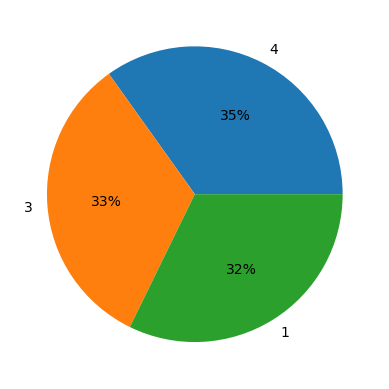

In [1254]:
plt.pie(labeled_data['labels'].value_counts(), labels=labeled_data['labels'].unique(), autopct='%1.0f%%')
plt.show()

In [1255]:
tfidf_vectorizer = model.named_steps["vector"]
selected_words = tfidf_vectorizer.get_feature_names_out().tolist()
print( f"Ejemplos de las palabras escogidas en el mejor modelo:\n{selected_words[0:15]}" )
print( f"\nEjemplos de las palabras escogidas en el mejor modelo:\n{selected_words[-15:]}" )

Ejemplos de las palabras escogidas en el mejor modelo:
['abaj', 'abandon', 'abarc', 'abiert', 'abog', 'abol', 'abord', 'aborigen', 'abort', 'abril', 'absolut', 'absorb', 'abus', 'acab', 'academ']

Ejemplos de las palabras escogidas en el mejor modelo:
['voluntari', 'volv', 'voz', 'vuelt', 'vuelv', 'vulner', 'washington', 'web', 'www', 'x', 'xx', 'york', 'zeland', 'zon', 'â']


In [1256]:
len(selected_words)

2677

Podemos ver que en el modelo final, se escogieron 2677 palabras distintas, las cuales fueron lemmatizadas y posteriormete vectorizadas utilizando el algoritmo de TF-IDF. El objetivo de esto es simplificar el análisis reduciendo la cantidad de palabras (con el lemmatizador) y dar un índice relativo a la importancia de cada token en cada texto (con el tf-idf vectorizer). El resultado, como visto anteriormente en la sección de preparación inicial de los datos, es un dataframe donde cada una de las filas representa un texto particular i, y las columnas son las palabras j que se encuentran en el documento. El valor en (i,j) es entonces el índice TF-IDF de la palabra j en el texto i, el cual mide la importancia de la palabra en relación a todos los textos.

## Trabajo en equipo